In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
# image 장 수 확인
style = 'anime'
base_train_dic = f'../prompt-to-prompt/{style}'

file_list = os.listdir(base_train_dic)

len(file_list)

3316

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms_

        self.files = sorted(glob.glob(root + "/*.png"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반, origin image 
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반, style image 

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [4]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageDataset(f"../prompt-to-prompt/{style}", transforms_=transforms_)

print(len(dataset))
train_size = int(0.85*len(dataset))
test_size = len(dataset) - train_size

3315


In [5]:
from torch.utils.data.dataset import random_split

train_dataset, val_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

In [6]:
batch_imgs = next(iter(train_dataloader))
print(batch_imgs['A'].size())
print(batch_imgs['B'].size())
#print(batch_x.shape, batch_y.shape) # batch, channel, width, height

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])


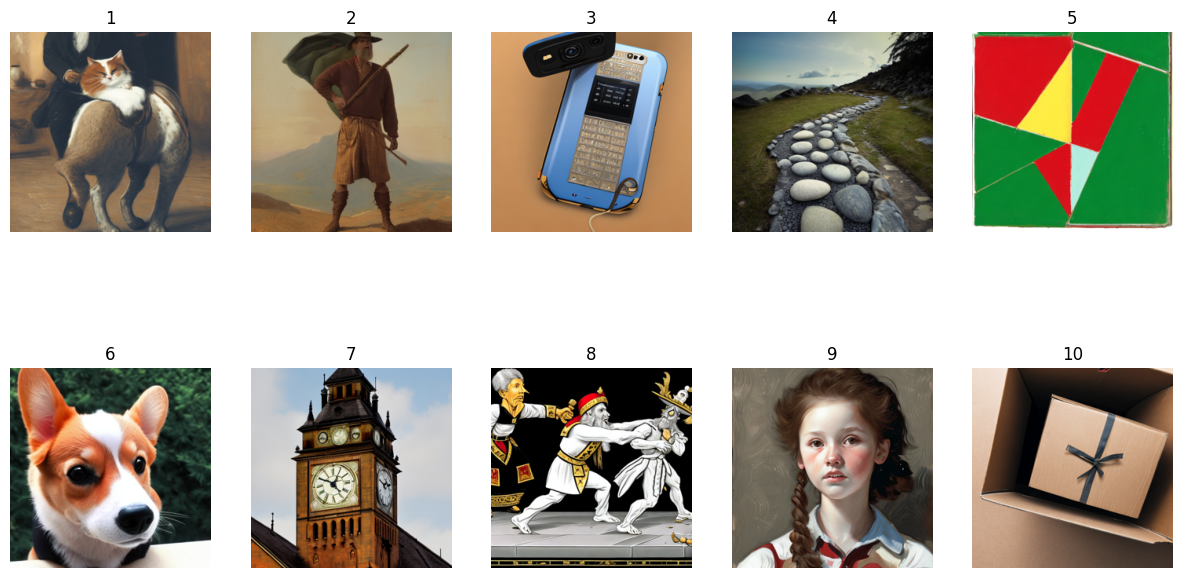

In [7]:
figure = plt.figure(figsize=(15,8))
rows, cols = 2, 5

for i in range(1, rows*cols +1):
    img_a = batch_imgs['A'][i-1]
    img_a = (img_a*0.5 + 0.5)
    img_a = img_a.permute(1,2,0)

    
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis('off')
    plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
        
    
plt.show()

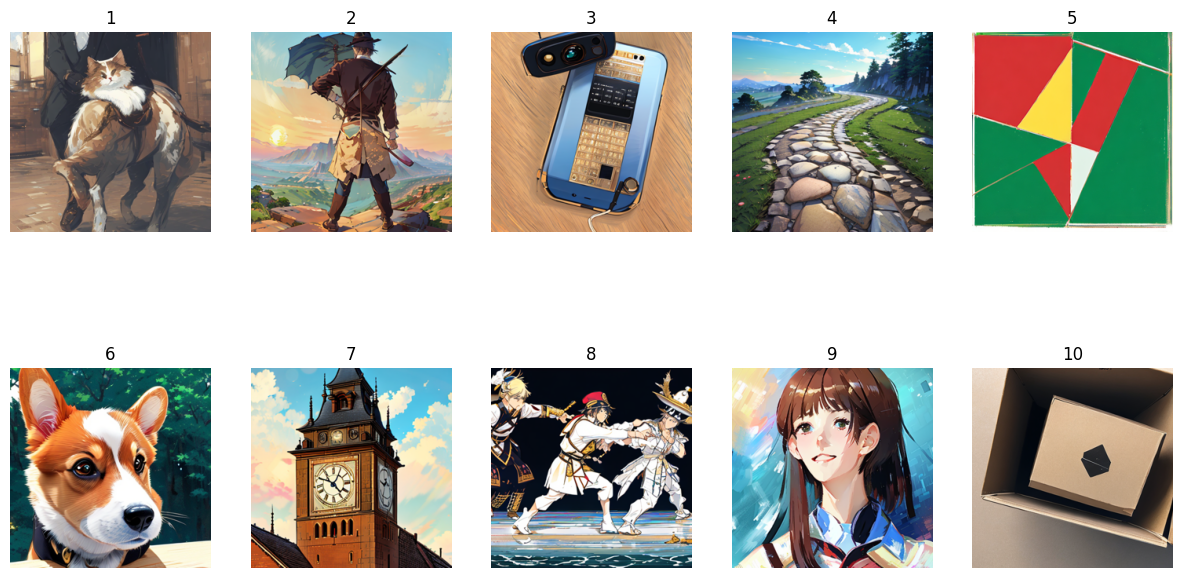

In [8]:
figure = plt.figure(figsize=(15,8))
rows, cols = 2, 5

for i in range(1, rows*cols +1):
    img_a = batch_imgs['B'][i-1]
    img_a = (img_a*0.5 + 0.5)
    img_a = img_a.permute(1,2,0)

    
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis('off')
    plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
        
    
plt.show()

In [14]:
"""style image를 reference로 주는 model. normalize나 reference 장 수 등의 추가 정보 없이도 critical 한 info이기 때문에 작동함"""

# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=False, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)]
        #layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input, style_input):
        x = self.model(x)
        x = torch.cat((x, skip_input,style_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x
        
class Conditioner(nn.Module):
    def __init__(self, in_channels=3):
        super(Conditioner, self).__init__()

        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.down1 = UNetDown(in_channels, 32) # 출력: [32 X 256 X 256]
        self.down2 = nn.Sequential(
            UNetDown(32,32),
            UNetDown(32,32),
            UNetDown(32, 32) # 출력: [32 X 256 X 256]
        )
        
        self.down3 = UNetDown(32, 64) # 출력: [64 X 128 X 128]
        self.down4 = nn.Sequential(
            UNetDown(64,64),
            UNetDown(64,64),
            UNetDown(64, 64) # 출력: [64 X 128 X 128]
        )
        self.down5 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down6 = nn.Sequential(
            UNetDown(128,128),
            UNetDown(128,128),
            UNetDown(128, 128) # 출력: [128 X 64 X 64]
        )
        self.down7 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down8 = nn.Sequential(
            UNetDown(256,256),
            UNetDown(256,256),
            UNetDown(256, 256) # 출력: [256 X 32 X 32]
        )
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1) #connect
        d3 = self.maxpool(d2)

        d4 = self.down3(d3)
        d5 = self.down4(d4) #connect
        d6 = self.maxpool(d5)

        d7 = self.down5(d6)
        d8 = self.down6(d7) #connect
        d9 = self.maxpool(d8)

        d10 = self.down7(d9)
        d11 = self.down8(d10) #connect

        return d2, d5, d8, d11

# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.Conditioner = Conditioner()
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.down1 = UNetDown(in_channels, 32) # 출력: [32 X 256 X 256]
        self.down2 = UNetDown(32, 32) # 출력: [32 X 256 X 256]
        
        
        self.down3 = UNetDown(32, 64) # 출력: [64 X 128 X 128]
        self.down4 = UNetDown(64, 64) # 출력: [64 X 128 X 128]
        
        self.down5 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down6 = UNetDown(128, 128) # 출력: [128 X 64 X 64]
        
        self.down7 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down8 = UNetDown(256, 256) # 출력: [256 X 32 X 32]

        self.middle1 = UNetDown(256,512) # 출력: [512 x 16 x 16]
        self.middle2 = UNetDown(512,512) # 출력: [512 x 16 x 16]
        
        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 256) # 출력: [512 X 32 X 32] #upsampling -> relu -> concat
        self.up2 = UNetDown(256*3,256*2) # 출력: [256 x 32 x 32] 
        self.up3 = UNetDown(256*2,256) # 출력: [256 x 32 x 32]
        
        self.up4 = UNetUp(256, 128) # 출력: [256 X 64 X 64] 
        self.up5 = UNetDown(128*3, 128*2) # 출력: [128 x 64 x 64]
        self.up6 = UNetDown(128*2,128) # 출력: [128 x 64 x 64]

        self.up7 = UNetUp(128, 64) # 출력: [128 x 128 x 128]
        self.up8 = UNetDown(64*3, 64*2) # 출력: [64 x 128 x 128]
        self.up9 = UNetDown(64*2, 64) # 출력: [64 x 128 x 128]

        self.up10 = UNetUp(64,32) # 출력: [64 x 256 x 256]
        self.up11 = UNetDown(32*3,32*2) # 출력: [32 x 256 x 256]
        self.up12 = UNetDown(32*2,32) # 출력: [32 x 256 x 256]
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size = 3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, style_x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        c1,c2,c3,c4 = self.Conditioner(style_x)
        
        d1 = self.down1(x)
        d2 = self.down2(d1) #connect
        d3 = self.maxpool(d2)

        d4 = self.down3(d3)
        d5 = self.down4(d4) #connect
        d6 = self.maxpool(d5)

        d7 = self.down5(d6)
        d8 = self.down6(d7) #connect
        d9 = self.maxpool(d8)

        d10 = self.down7(d9)
        d11 = self.down8(d10) #connect
        d12 = self.maxpool(d11)

        d13 = self.middle1(d12)
        d14 = self.middle2(d13)
    
        d15 = self.up1(d14,d11,c4)
        d16 = self.up2(d15)
        d17 = self.up3(d16)

        d18 = self.up4(d17,d8,c3)
        d19 = self.up5(d18)
        d20 = self.up6(d19)

        d21 = self.up7(d20, d5,c2)
        d22 = self.up8(d21)
        d23 = self.up9(d22)

        d24 = self.up10(d23, d2,c1)
        d25 = self.up11(d24)
        d26 = self.up12(d25)

        return self.final(d26)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [15]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(DEVICE)
generator.to(DEVICE)
discriminator.to(DEVICE)

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

cuda:1


In [18]:
import time

n_epochs = 300 # 학습의 횟수(epoch) 설정
sample_interval = 1000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["A"].to(DEVICE) # origin
        real_B = batch["B"].to(DEVICE) # style

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0).to(DEVICE) # 진짜(real): 1
        fake = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0).to(DEVICE) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A, real_B)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["A"].to(DEVICE)
            real_B = imgs["B"].to(DEVICE)
            fake_B = generator(real_A, real_B)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"./anime_unet_with_condition_result/{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}]")

[Epoch 0/300] [D loss: 0.122714] [G pixel loss: 0.102118, adv loss: 1.166675329208374]
[Epoch 1/300] [D loss: 0.151228] [G pixel loss: 0.073779, adv loss: 0.3899114429950714]
[Epoch 2/300] [D loss: 0.101597] [G pixel loss: 0.063540, adv loss: 0.4437490403652191]
[Epoch 3/300] [D loss: 0.067071] [G pixel loss: 0.060521, adv loss: 0.9259780645370483]
[Epoch 4/300] [D loss: 0.184279] [G pixel loss: 0.086478, adv loss: 0.2985556721687317]
[Epoch 5/300] [D loss: 0.196212] [G pixel loss: 0.045892, adv loss: 0.9270374178886414]
[Epoch 6/300] [D loss: 0.148028] [G pixel loss: 0.048605, adv loss: 0.3644914925098419]
[Epoch 7/300] [D loss: 0.050808] [G pixel loss: 0.039862, adv loss: 0.642861545085907]
[Epoch 8/300] [D loss: 0.049042] [G pixel loss: 0.058638, adv loss: 0.9179264307022095]
[Epoch 9/300] [D loss: 0.061655] [G pixel loss: 0.063561, adv loss: 0.5520839095115662]
[Epoch 10/300] [D loss: 0.166136] [G pixel loss: 0.051014, adv loss: 0.8202418088912964]
[Epoch 11/300] [D loss: 0.090744]

KeyboardInterrupt: 

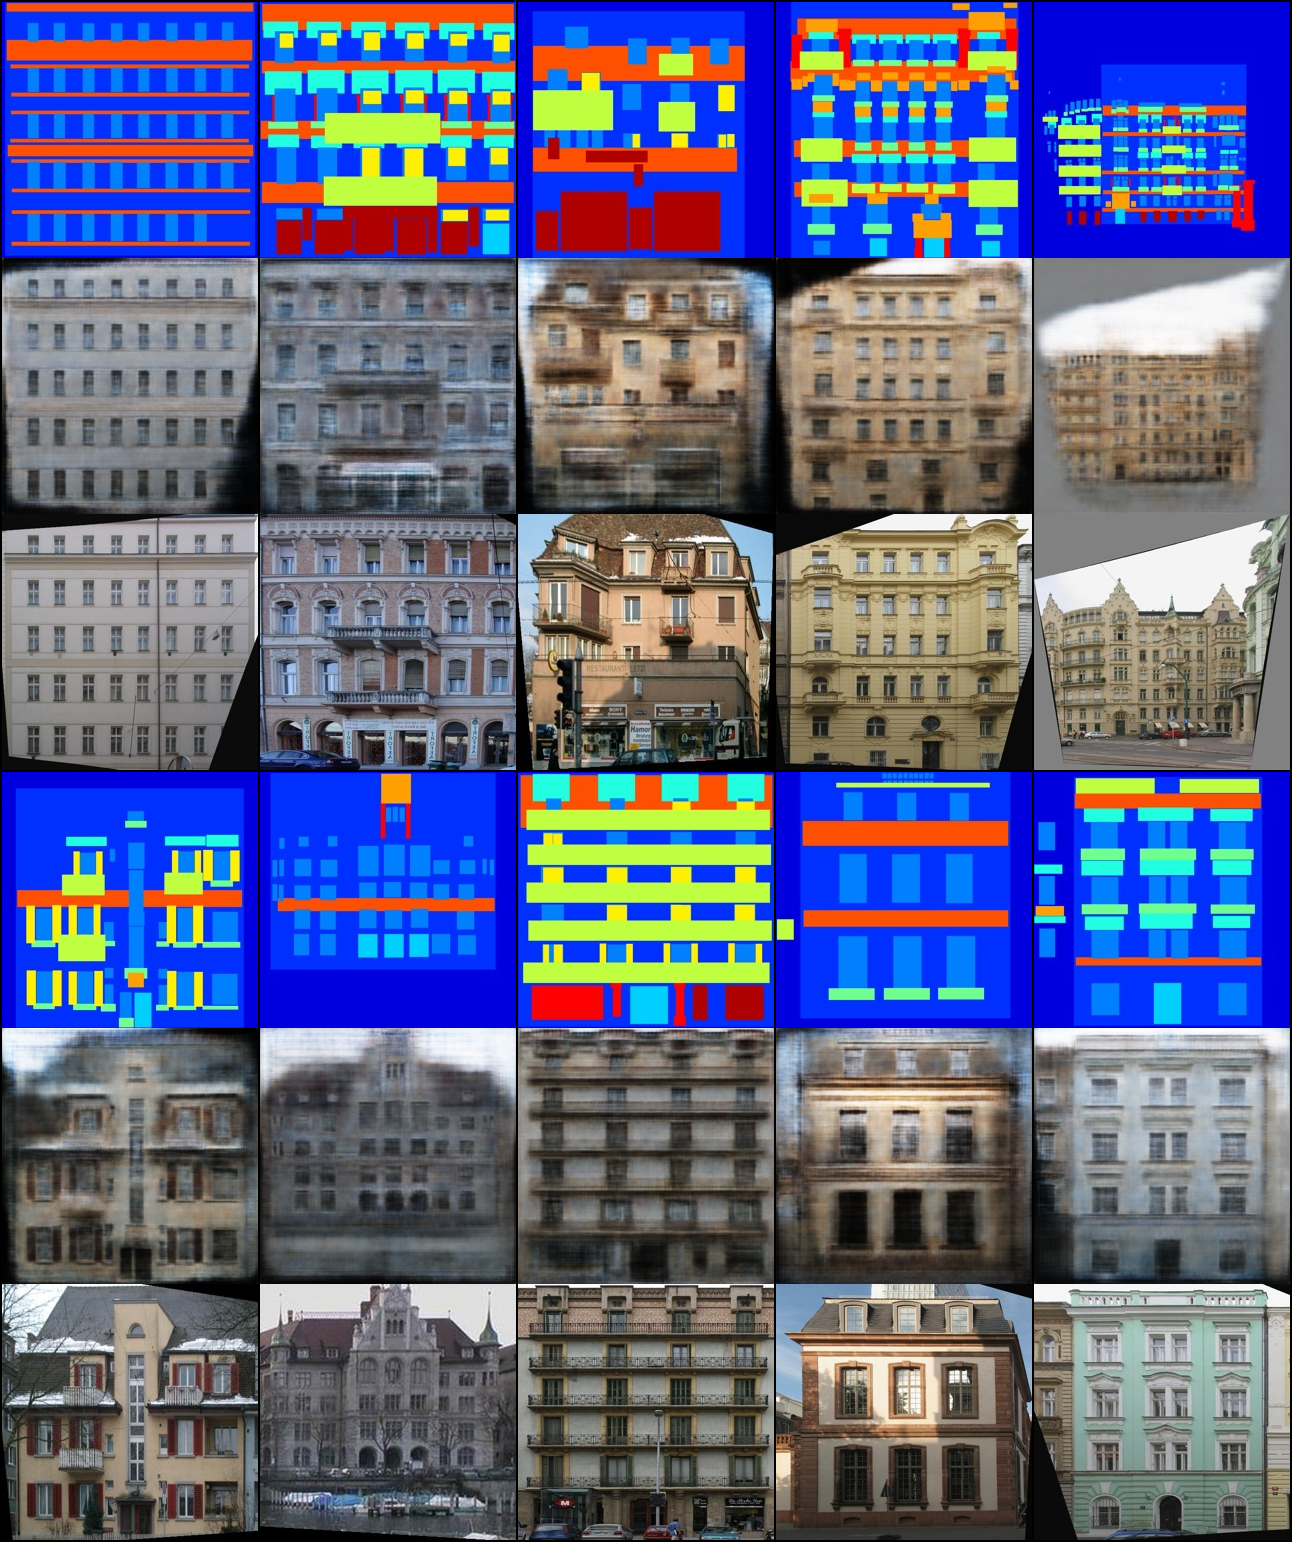

In [1]:
from IPython.display import Image

Image('10000.png')